In [29]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

In [30]:
class CNN_LSTM(nn.Module):
    def __init__(self):
        super(CNN_LSTM, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=12, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv1d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1)
        self.lstm = nn.LSTM(input_size=256, hidden_size=128, num_layers=2, batch_first=True)
        self.fc1 = nn.Linear(128, 64)
        self.fc2 = nn.Linear(64, 14)

    def forward(self, x):
        x = x.permute(0, 2, 1)  # Change shape from (batch_size, seq_len, num_features) to (batch_size, num_features, seq_len)
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = x.permute(0, 2, 1)  # Change back to (batch_size, seq_len, num_features)
        x, _ = self.lstm(x)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [31]:
# Load data
X = np.load('/kaggle/input/mydata/X_train_padding.npy')
Y = np.load('/kaggle/input/mydata/y_train_padding.npy')

# Convert numpy arrays to PyTorch tensors
X_tensor = torch.tensor(X, dtype=torch.float32)
Y_tensor = torch.tensor(Y, dtype=torch.float32)

# Create a TensorDataset and DataLoader
dataset = TensorDataset(X_tensor, Y_tensor)
dataloader = DataLoader(dataset, batch_size=8, shuffle=True)

In [32]:
# Initialize the model, loss function, and optimizer
model = CNN_LSTM()
if torch.cuda.is_available():
    model = model.to('cuda')
criterion = nn.MSELoss()  # Assuming a regression problem
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [33]:
num_epochs = 10
all_losses = []

Epoch [1/10], Avg. Loss: 1685.7270
Epoch [2/10], Avg. Loss: 1357.5204
Epoch [3/10], Avg. Loss: 919.2833
Epoch [4/10], Avg. Loss: 719.2019
Epoch [5/10], Avg. Loss: 685.6713
Epoch [6/10], Avg. Loss: 682.9306
Epoch [7/10], Avg. Loss: 686.9652
Epoch [8/10], Avg. Loss: 680.5731
Epoch [9/10], Avg. Loss: 682.6632
Epoch [10/10], Avg. Loss: 680.6165


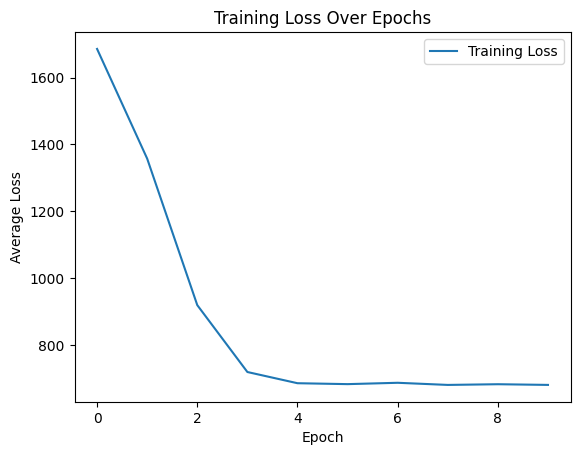

In [34]:
for epoch in range(num_epochs):
    epoch_loss = 0.0

    for batch_data, batch_target in dataloader:
        if torch.cuda.is_available():
            batch_data, batch_target = batch_data.to('cuda'), batch_target.to('cuda')
        optimizer.zero_grad()
        outputs = model(batch_data)
        loss = criterion(outputs, batch_target)  # Ensure target shape matches output shape
        loss.backward()
        optimizer.step()

        # Accumulate the loss for the current batch
        epoch_loss += loss.item()

    # Calculate average loss for the epoch
    avg_epoch_loss = epoch_loss / len(dataloader)

    # Print the average loss for the epoch
    print(f'Epoch [{epoch+1}/{num_epochs}], Avg. Loss: {avg_epoch_loss:.4f}')

    # Save the average loss for plotting
    all_losses.append(avg_epoch_loss)

# Plot the training loss
plt.plot(all_losses, label='Training Loss')
plt.savefig('CNN_LSTM_training_loss.png')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
plt.legend()
plt.show()